# IKZF1
[common variable immunodeficiency-13 (CVID13)](https://omim.org/entry/616873) is caused by heterozygous mutation in the IKZF1 gene. CVID13 is an autosomal dominant primary immunodeficiency disorder characterized by recurrent bacterial infections, mainly affecting the respiratory tract, and associated with hypogammaglobulinemia and decreased numbers of B cells. The age at onset of clinical features can range from infancy to adulthood.
Many published IKZF1 vairants are thought to be loss of function ([PMID: 31057532](https://pubmed.ncbi.nlm.nih.gov/31057532/)). Heterozygous mutations affecting amino acid N159 located in the DNA-binding domain of IKZF1 are thought to act in a dominant-negative fashion and were reported to be associated with early-onset and severe manifestations often including
Pneumocystis jirovecii pneumonia ([PMID:](29889099)https://pubmed.ncbi.nlm.nih.gov/29889099/).
Here, we test a cohort of individuals with pathogenic IKZF1 variants.

Germline variants in IKZF1 encoding for the lymphoid transcription factor IKAROS, are associated with inborn errors of immunity characterized by immune dysregulation, autoimmunity and an increased risk for malignancy. IKAROS is important in hematopoietic development, but also required for the development of autoimmune regulator-positive (AIRE+) mTEC (Sin et al. 2023).  Knowledge of the genotype-phenotype correlations such as the ones described above has the great potential to improve patient management.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### IKZF
We used the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for IKZF.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service
gene_symbol = 'IKZF1'
mane_tx_id = 'NM_006060.6'
mane_protein_id = 'NP_006051.1' # DNA-binding protein Ikaros isoform 1
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 82 phenopackets
Individuals Processed: 100%|██████████| 82/82 [00:17<00:00,  4.62 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
61,B lymphocytopenia
50,Decreased circulating IgA concentration
49,Decreased circulating total IgM
46,Decreased circulating IgG concentration
29,Decreased CD4:CD8 ratio
22,Decreased proportion of memory B cells
17,Recurrent infections
16,Decreased proportion of CD4-positive T cells
14,Recurrent pneumonia
14,Pneumocystis jirovecii pneumonia


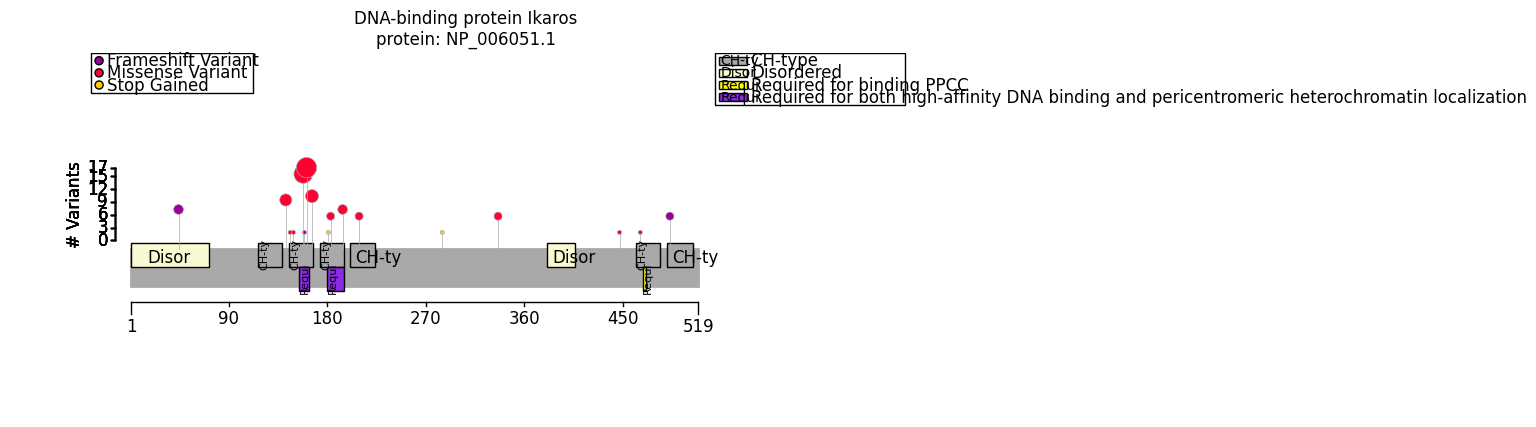

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

IKZF1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
IKZF1_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
3,Disordered,Region,2 - 72,p.Ser46AlafsTer14
0,C2H2-type 1,Zinc finger,118 - 139,
40,C2H2-type 2,Zinc finger,146 - 167,p.Arg162Gln; p.Asn159Thr; p.His167Tyr; p.Cys147Arg; p.Asn159Ser; p.Cys150Arg; p.His163SerfsTer32; p.Arg162Leu; p.Arg162Trp; p.His167Arg
32,Required for both high-affinity DNA binding and pericentromeric heterochromatin localization,Region,155 - 163,p.Arg162Gln; p.Asn159Thr; p.Asn159Ser; p.His163SerfsTer32; p.Arg162Trp; p.Arg162Leu
6,C2H2-type 3,Zinc finger,174 - 195,p.Cys182Ter; p.His195Arg; p.Arg184Gln
6,Required for both high-affinity DNA binding and pericentromeric heterochromatin localization,Region,181 - 195,p.Cys182Ter; p.His195Arg; p.Arg184Gln
2,C2H2-type 4,Zinc finger,202 - 224,p.Tyr210Cys
0,Disordered,Region,382 - 406,
1,C2H2-type 5,Zinc finger,463 - 484,p.Cys467Trp
0,Required for binding PP1CC,Region,469 - 471,


# Genotype-Phenotype Correlation (GPC) Analysis

In [7]:
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [8]:
from gpsea.analysis.predicate import variant_key
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.view import MtcStatsViewer

asn159ser = variant_key("7_50382594_50382594_A_G") # p.Asn159Ser	
asn159ser_clf = monoallelic_classifier(
    a_predicate=asn159ser,
    b_predicate= ~asn159ser,
    a_label='p.Asn159Ser',
    b_label='Other variant'
)

asn159ser_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=asn159ser_clf,
    pheno_clfs=pheno_clfs,
)
viewer = MtcStatsViewer()
viewer.process(asn159ser_result)


Reason,Count
Skip terms if all counts are identical to counts for a child term,3
Skipping term because one genotype had zero observations,5
"Skipping ""general"" level terms",59
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),120


In [9]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, asn159ser_result)

Allele group,p.Asn159Ser,Other variant,Corrected p values,p values
Recurrent pneumonia [HP:0006532],7/9 (78%),7/39 (18%),0.035093,0.001210
T-cell acute lymphoblastic leukemias [HP:0006727],3/13 (23%),0/69 (0%),0.046827,0.003229
Recurrent otitis media [HP:0000403],3/6 (50%),7/48 (15%),0.551436,0.069665
Decreased circulating total IgM [HP:0002850],9/9 (100%),40/56 (71%),0.551436,0.098276
Recurrent sinusitis [HP:0011108],1/1 (100%),5/50 (10%),0.551436,0.117647
Decreased CD4:CD8 ratio [HP:0033222],1/7 (14%),28/59 (47%),0.551436,0.124361
Chronic diarrhea [HP:0002028],1/1 (100%),6/49 (12%),0.551436,0.140000
Decreased circulating IgG concentration [HP:0004315],8/8 (100%),38/51 (75%),0.551436,0.179936
Decreased circulating IgA concentration [HP:0002720],9/9 (100%),41/54 (76%),0.551436,0.183902
B lymphocytopenia [HP:0010976],13/13 (100%),48/58 (83%),0.551436,0.190150


In [10]:
from gpsea.analysis.predicate import variant_effect
from gpsea.model import VariantEffect

missense = variant_effect(VariantEffect.MISSENSE_VARIANT,  mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="Missense",
    b_label="oher"
)
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, missense_result)

Allele group,Missense,oher,Corrected p values,p values
Recurrent otitis media [HP:0000403],10/33 (30%),0/21 (0%),0.145790,0.004288
Recurrent pneumonia [HP:0006532],13/31 (42%),1/17 (6%),0.156564,0.009210
Autoimmune thrombocytopenia [HP:0001973],6/36 (17%),0/22 (0%),0.831737,0.073389
Decreased CD4:CD8 ratio [HP:0033222],22/43 (51%),7/23 (30%),0.893446,0.125422
B lymphocytopenia [HP:0010976],46/51 (90%),15/20 (75%),0.893446,0.131389
Decreased circulating IgG concentration [HP:0004315],34/41 (83%),12/18 (67%),0.903654,0.187394
Recurrent bronchitis [HP:0002837],3/18 (17%),0/18 (0%),0.903654,0.228571
B Acute Lymphoblastic Leukemia [HP:0004812],1/56 (2%),2/26 (8%),0.903654,0.234869
Recurrent oral herpes [HP:0410028],3/22 (14%),0/17 (0%),0.903654,0.242915
Recurrent bacterial skin infections [HP:0005406],3/26 (12%),0/17 (0%),0.903654,0.265781


# Summary

In [11]:
caption = """The variant p.Asn159Ser was functionally characterized to be dominant-negative and result in a combined-immunodeficiency phenotype that 
was distinct from other IKZF1 variants \\cite{ by Boutboul et al. 2019}."""

from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

fet_results = (
    GPAnalysisResultSummary.from_multi(
        result=asn159ser_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
)

report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=fet_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [12]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [13]:
summarizer.process_latex(report=report, protein_fig=IKZF1_fig)

Figure saved to ../../supplement/img/IKZF1_protein_diagram-draft.pdf
Output to ../../supplement/tex/IKZF1_summary_draft.tex
